# Problema de clasificación de emociones por expresiones faciales

A lo largo de este notebook explicaré cómo utilizar el poder del cómputo en la nube a través de Google CoLab para resolver el siguiente problema: clasificar emociones mediante expresiones faciales.

Para este problema de clasificación, utilizaremos una arquitectura basada en LeNet-5 ([*LeCunn et. al, 1998*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)), una arquitectura de Red Neuronal Convolucional (CNN, Convolutional Neural Network) que se describirá en un momento.

El paquete principal de Python que estaremos utilizando será [Keras](https://keras.io/).


### Planteamiento del problema

Antes de atacar el problema con una CNN, entendamos lo que estaremos realizando: Si capturamos la imagen del rostro de una persona, queremos ser capaces de determinar la emoción evocada a través de la expresión facial.


#### ¿Qué necesitamos hacer?

Entrenar un modelo de aprendizaje profundo (en este caso) utilizando una base de datos propia: `FER_CIMAT_DATASET` (*Mitre & Mitre, 2018.*).


#### > La base de datos de rostros < (*Ver muestras de la misma.*)

# Pre-procesamiento de los datos

#### Buenas noticias:

El corpus de la base de datos `FER_CIMAT_DATASET`, por su naturaleza, no requiere un tratamiento previo de modificación a la imagen. De cualquier manera, las imágenes han sido re-escaladas para el modelo de entrenamiento.

Sólo necesitamos importar la base de datos utilizando `PyDrive` y dividir los datos en conjuntos de prueba y de entrenamiento (para posteriormente poder realizar las evaluaciones de precisión).

Para instalar `PyDrive` en Google CoLab corremos el siguiente comando:

In [0]:
!pip install -U -q PyDrive

### Importando los datos:

Posterior a ello, importamos los paquetes necesarios y creamos los autenticadores de los archivos en Google Drive, para posteriormente importar los datos:

In [0]:
# Importamos paquetería para trabajar sobre Google Drive:
from oauth2client.client import GoogleCredentials
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from google.colab import files
from google.colab import auth
import pickle

# Autenticamos nuestra cuenta en Google Drive (para obtener los datos):
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Insertamos los identificadores de los archivos:
x_id = '1Zuq_y1Xy5W-pPtFnvPGeMvy_jRqbZr3y'
y_id = '1LQAYnBPwccXDJ6mUS1T-Nj21NvGWZTLg'

Ahora podemos importar desde Google Drive (de manera remota) los archivos a utilizar:

In [0]:
# Etiquetas de emociones:
y_file = drive.CreateFile({'id': y_id})
y_file.GetContentFile("y.dat")
y_raw = pickle.load(open("y.dat", "rb"))

# Emociones en crudo:
x_file = drive.CreateFile({'id': x_id})
x_file.GetContentFile("X.dat")
x_raw = pickle.load(open("X.dat", "rb"))

### Pre-procesando los datos:

Procedemos a dividir los datos en conjuntos de entrenamiento y prueba como sigue:

In [16]:
# Importamos paquetes auxiliares:
from sklearn.utils import shuffle
from keras.utils import np_utils
import numpy as np
import random

# Definimos parámetros de los datos:
# random_state = random.randint(1, 50)
random_state = 11
print(random_state)
train_split = .9
num_classes = 8

# Mezclamos por clases:
unique_values, indexes, counts = np.unique(y_raw, return_index=True, return_counts=True)

x_train, y_train, x_test, y_test = [], [], [], []

for value, index, count in zip(unique_values, indexes, counts):
    # Tomamos valores:
    x_values = x_raw[index:index+count]
    y_values = y_raw[index:index+count]

    # Mezclamos los datos:
    x_values, y_values = shuffle(x_values, y_values, random_state=random_state)
    
    # Dividimos los datos:
    longitud = int(len(x_values)*train_split)
    x_train.extend(x_values[:longitud])
    y_train.extend(y_values[:longitud])
    x_test.extend(x_values[longitud:])
    y_test.extend(y_values[longitud:])


# Vectorizamos:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

11


Procedemos a obtener las dimensiones de los datos, así como a cada etiqueta convertirla en vector categórico:

In [17]:
# Obtener dimensiones:
img_height, img_width, channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
print("Dimensiones de imagen: {}x{}".format(img_height, img_width))
print("Número de canales: {}".format(channels))

# Convertir a "one hot encoding":
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

Dimensiones de imagen: 224x224
Número de canales: 3


Ahora sí, comienza lo bueno.

## Hablemos sobre el modelo...

Utilizaremos un modelo basado en LeNet-5, que es una CNN con la siguiente arquitectura:

![LeNet-5](https://raw.githubusercontent.com/RodolfoFerro/MeetupHCC18/master/more/LeNet-5.png)
Fuente: ([*"Gradient-Based Learning Applied to Document Recognition", LeCunn et. al, 1998*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf))

## ¡A armar el modelo!

Primero importemos todo lo que utilizaremos:

In [0]:
# Importemos nuestro contenido desde Keras:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D

from keras import backend as K
K.set_image_dim_ordering('tf')

Y definamos la arquitectura a partir de un modelo secuencial:

In [0]:
def LeNet5_pero_tuneado(input_shape=(img_height, img_width, channels)):
    """Modelo de CNN basado en LeNet-5."""
    
    # Creamos el modelo:
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))  # Intentemos evitar el 'overfitting'...
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo:
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    
    return model

### Nuestra arquitectura:

![Aquí debería haber una imagen...](https://raw.githubusercontent.com/RodolfoFerro/MeetupHCC18/master/more/model.svg)

#### Rcursos útiles:

- Modelo secuencial en Keras: https://keras.io/getting-started/sequential-model-guide/
- ¿Qué es *Dropout*?: http://jmlr.org/papers/v15/srivastava14a.html

### Armamos el modelo:

In [23]:
# Armamos el modelo:
model = LeNet5_pero_tuneado()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 108, 108, 15)      4065      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 15)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 54, 15)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 43740)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               4374100   
__________

### Entrenamos el modelo:

Para ello, definiemos los hiperparámetros de entrenamiento.

(**No olvidar cambiar el *'runtime'* por GPU para liberar el poder de las tarjetas gráficas de Google...**)

In [24]:
# Definimos hiperparámetros:
batch_size = 128
epochs = 10

# Entrenamos el modelo:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          epochs=epochs, batch_size=batch_size)

Train on 6572 samples, validate on 734 samples
Epoch 1/10
6572/6572 [==============================] - 16s 3ms/step - loss: 8.6006 - acc: 0.4659 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 2/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 3/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 4/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 5/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 6/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 7/10
6572/6572 [==============================] - 16s 2ms/step - loss: 8.5079 - acc: 0.4722 - val_loss: 8.5422 - val_acc: 0.4700
Epoch 8/

### Evaluamos los resultados:

Para ello imprimimos los resultados sobre los datos de prueba:

In [25]:
# Evaluación final del modelo:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Precisión sobre conjunto de prueba:', scores[1])

734/734 [==============================] - 1s 2ms/step
Precisión sobre conjunto de prueba: 0.47002724795640327


Más aún, podemos ver el proceso de aprendizaje a lo largo del tiempo. Para ello creamos un par de funciones para visualizar dicho proceso de aprendizaje.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(history, path):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(path)


def plot_acc(history, path):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title("Model's training acc")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(path)

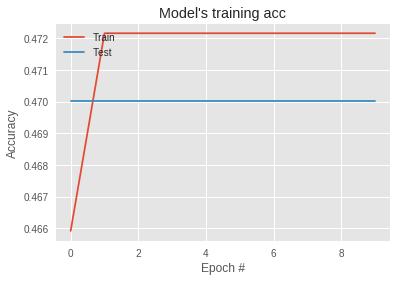

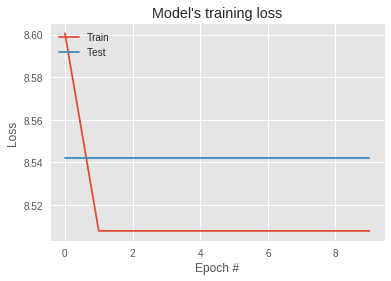

In [27]:
# Plot loss and accuracy:
plot_acc(history, 'model_accuracy.png')
plot_loss(history, 'model_loss.png')

### Guardamos archivos:

Y para guardar los archivos generados en Google Drive:

In [13]:
# Guardamos los archivos generados:
files.download('model_accuracy.png')
files.download('model_loss.png')

# Subimos los archivos generados a Google Drive:
uploaded = drive.CreateFile({'title': 'model_accuracy.png'})
uploaded.SetContentFile("model_accuracy.png")
uploaded.Upload()
print('Archivo subido con ID: {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'model_loss.png'})
uploaded.SetContentFile("model_loss.png")
uploaded.Upload()
print('Archivo subido con ID: {}'.format(uploaded.get('id')))


Archivo subido con ID: 1oda9-rhpM_KcGI56fRt3hW9AeK_3eo2o
Archivo subido con ID: 16WIQbpyRVDmGaznIqrscjcTFxDvjvOow


In [14]:
# Serializar modelo a JSON:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serializar pesos a HDF5 (se necesita h5py):
model.save_weights("model.h5")
print("Modelo guardado en disco.")

files.download('model.json')
files.download('model.h5')

Modelo guardado en disco.


### Cargamos modelos:

Básicamente hacemos dos cosas:
1. Cargamos el modelo desde un archivo JSON.
2. Cargamos los pesos desde un archivo HDF5. 

In [0]:
# Cargamos json y creamos el modelo:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Cargamos pesos al modelo:
loaded_model.load_weights("model.h5")
print("Loaded model from disk")